In [1]:
from util.io import load_ckpt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from models.PConv_layer import PConv2D
from models.Depthwise_PConv_layer import PConv2D_depthwise


class EncoderLayer(nn.Module):
    def __init__(self, in_channels, kernel_size, depth_multiplier, stride=2, bn=True):
        super().__init__()
        
        self.pconv = PConv2D_depthwise(in_channels,  kernel_size, depth_multiplier,stride=stride, padding='same')
        self.bn = nn.BatchNorm2d(in_channels * depth_multiplier) if bn else None
        self.activation = nn.ReLU()
        # self.leaky_relu = nn.LeakyReLU(0.2)

    def forward(self, img_in, mask_in):
        img_out, mask_out = self.pconv([img_in, mask_in])
        if self.bn is not None:
            img_out = self.bn(img_out)
        img_out = self.activation(img_out)
        return img_out, mask_out
    
class DecoderLayer(nn.Module):
    def __init__(self,in_channels, out_channels, kernel_size, bn=True):
        super().__init__()
        # self.upsampling_mode = upsampling_mode
        
        self.up = nn.Upsample(scale_factor=2, mode='nearest')
        
        self.kernel_size = kernel_size
        self.pconv = PConv2D(in_channels=in_channels+out_channels, out_channels=out_channels,  kernel_size=kernel_size, padding='valid', stride=1, dilation=1)
        
        self.bn = nn.BatchNorm2d(out_channels) if bn else None
        self.leaky_relu = nn.LeakyReLU(0.4)

    def forward(self, img_in, mask_in, e_conv, e_mask):
        
        img_in_up = self.up(img_in)
        mask_in_up = self.up(mask_in)
        
        
        concat_img = torch.cat([e_conv, img_in_up], dim=1)
        concat_mask = torch.cat([e_mask, mask_in_up], dim=1)
        img_out, mask_out = self.pconv([concat_img, concat_mask])
        
        if self.bn is not None:
            img_out = self.bn(img_out)
        img_out = self.leaky_relu(img_out)
        return img_out, mask_out

class PConvUNet(nn.Module):
    def __init__(self, img_channels=3):
        super().__init__()
        # Define encoder layers
        self.e1 = EncoderLayer(img_channels, kernel_size=7, depth_multiplier=4, bn=False)
        self.e2 = EncoderLayer(img_channels * 4, kernel_size=5, depth_multiplier=2)
        self.e3 = EncoderLayer(img_channels * 8, kernel_size=5, depth_multiplier=2)
        self.e4 = EncoderLayer(img_channels * 16, kernel_size=3, depth_multiplier=2)
        self.e5 = EncoderLayer(img_channels * 32, kernel_size=3, depth_multiplier=2)
        self.e6 = EncoderLayer(img_channels * 64, kernel_size=3, depth_multiplier=1)
        # self.e7 = EncoderLayer(img_channels * 128, kernel_size=3, depth_multiplier=1)
        
        bottle_neck = img_channels * 64
        
        # self.d1 = DecoderLayer(bottle_neck, bottle_neck, kernel_size=3)

        
        self.d2 = DecoderLayer(bottle_neck, bottle_neck, kernel_size=3)
        self.d3 = DecoderLayer(bottle_neck, bottle_neck//2, kernel_size=3)
        self.d4 = DecoderLayer(bottle_neck//2, bottle_neck//4, kernel_size=3)
        self.d5 = DecoderLayer(bottle_neck//4, bottle_neck//8, kernel_size=3)
        self.d6 = DecoderLayer(bottle_neck//8, bottle_neck//16, kernel_size=3)
        self.d7 = DecoderLayer(bottle_neck//16, img_channels, kernel_size=3)
        # Define final output layer
        self.final_conv = nn.Conv2d(img_channels, 1, kernel_size=1)
        self.final_activation = nn.Sigmoid()
        # self.final_activation = nn.ReLU()

    def forward(self, inputs_img, inputs_mask):
        # Forward pass through encoder layers
        e_conv1, e_mask1 = self.e1(inputs_img, inputs_mask)
        
        e_conv2, e_mask2 = self.e2(e_conv1, e_mask1)
        e_conv3, e_mask3 = self.e3(e_conv2, e_mask2)
        e_conv4, e_mask4 = self.e4(e_conv3, e_mask3)
        e_conv5, e_mask5 = self.e5(e_conv4, e_mask4)
        e_conv6, e_mask6 = self.e6(e_conv5, e_mask5)
        # e_conv7, e_mask7 = self.e7(e_conv6, e_mask6)
        
        
        # # # Continue through all encoder and decoder layers...
        
        # d_conv1, d_mask1 = self.d1(e_conv7, e_mask7, e_conv6, e_mask6)
        d_conv2, d_mask2 = self.d2(e_conv6, e_mask6, e_conv5, e_mask5)
        # d_conv2, d_mask2 = self.d2(d_conv1, d_mask1, e_conv5, e_mask5)
        d_conv3, d_mask3 = self.d3(d_conv2, d_mask2, e_conv4, e_mask4)
        d_conv4, d_mask4 = self.d4(d_conv3, d_mask3, e_conv3, e_mask3)
        d_conv5, d_mask5 = self.d5(d_conv4, d_mask4, e_conv2, e_mask2)
        d_conv6, d_mask6 = self.d6(d_conv5, d_mask5, e_conv1, e_mask1)
        
        d_conv7, d_mask7 = self.d7(d_conv6, d_mask6, inputs_img, inputs_mask)
        
        
        # # # Final output layer
        outputs = self.final_conv(d_conv7)
        outputs = self.final_activation(outputs)
        
        return inputs_mask, e_mask1, e_mask2, e_mask3, e_mask4, e_mask5, e_mask6, outputs
        return outputs




In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ckpt = '/tng4/users/skayasth/Yearly/2024/Feb/other_imp/torch_pconv/snapshots/Sigmoid/ckpt/100000.pth'
model = PConvUNet(5).to(device)
print('Loading Checkpoint')
load_ckpt(ckpt, [('model', model)])

Loading Checkpoint


100000

In [12]:
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
numpy_array = np.load('/tng4/users/skayasth/Yearly/2024/Feb/Gated_2024/generative-inpainting-pytorch/test_2019.npy')
# numpy_array = np.load('/tng4/users/skayasth/Yearly/2024/Feb/Gated_2024/generative-inpainting-pytorch/numpy_array.npy')
print('Creating Dataloader')
tensor_array = torch.tensor(numpy_array, dtype=torch.float32)
dataset = TensorDataset(tensor_array)
test_dataloader = DataLoader(
    dataset, batch_size=1,
    num_workers=0)


Creating Dataloader


In [13]:
def create_mask(batch_size, channels, height, width):
    mask_first_channel = torch.rand(batch_size, 1, height, width) < 0.05  # 10% data present, 90% data missing in the first channel
    mask_other_channels = torch.ones(batch_size, channels - 1, height, width)  # All data present in other channels

    # Concatenate the masks for the first channel and the other channels
    mask_combined = torch.cat([mask_first_channel, mask_other_channels], dim=1).float()

    return mask_combined

In [14]:
iterator_train = iter(test_dataloader)
image = [x for x in next(iterator_train)][0]
gt = image
batch, channels, height, width = image.shape
mask = create_mask(1, channels, height, width)

In [15]:
image = image.to(device)
mask = mask.to(device)
gt = gt.to(device)


In [16]:
mask.shape

torch.Size([1, 5, 128, 256])

In [17]:
model.eval()
with torch.no_grad():
    output = model(image, mask)

In [18]:
128*256

32768

tensor(31127, device='cuda:0')
tensor(735, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')


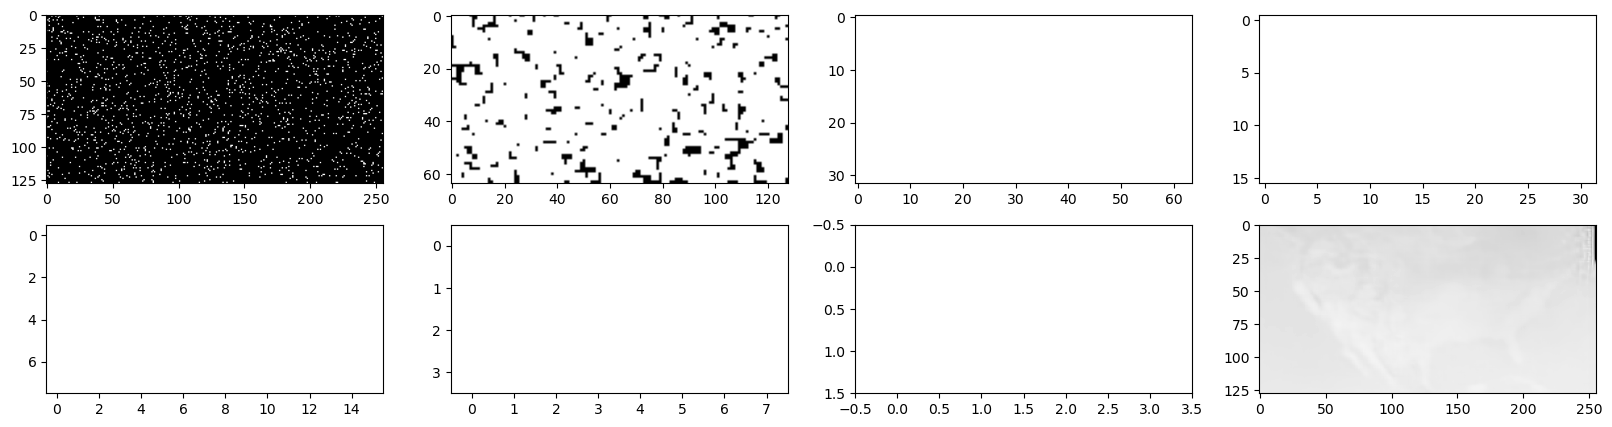

In [19]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 4, figsize=(20, 5))
axes = ax.flatten()
for i in range(8):
    
    print(torch.sum(output[i][0,0,:,:]==0))
    
    axes[i].imshow(output[i][0,0,:,:].cpu().numpy().squeeze(), cmap='gray', vmin=0, vmax=1)
   

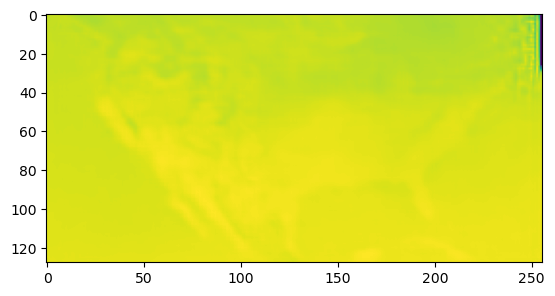

In [ ]:
plt.imshow(output[-1][0,0,:,:].cpu().numpy().squeeze())

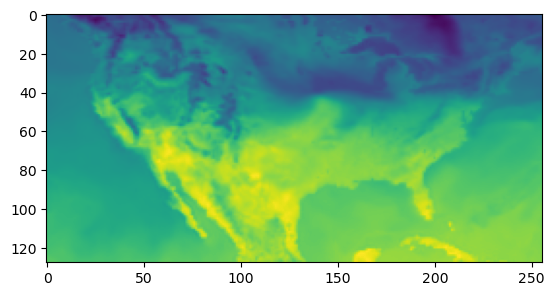

In [ ]:
plt.imshow(gt[0,0,:,:].cpu().numpy().squeeze())

In [ ]:
from models.Depthwise_PConv_layer import DepthwiseConv2D        
class PConv2D_depthwise(nn.Module):
    def __init__(self, in_channels, kernel_size, depth_multiplier=4, stride=1, padding='valid', dilation=1, bias=True):
        super(PConv2D_depthwise, self).__init__()
        
        self.depth_multiplier = depth_multiplier 
        self.in_channels = in_channels
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.out_channels = in_channels * self.depth_multiplier
        padding = 'valid'
        
        # Initialize depthwise convolutions for both input and mask
        self.input_conv = DepthwiseConv2D(in_channels, kernel_size, stride, padding, dilation, bias=bias, depth_multiplier=self.depth_multiplier)
        self.mask_conv = DepthwiseConv2D(in_channels, kernel_size, stride, padding, dilation, bias=False, depth_multiplier=self.depth_multiplier)

        # Assuming kernel_size is a tuple
        kernel_size = (kernel_size, kernel_size)
        self.kernel_size = kernel_size
        self.window_size = kernel_size[0] * kernel_size[1]

        if bias:
            self.bias = nn.Parameter(torch.Tensor(in_channels*self.depth_multiplier))
            self.bias.data.fill_(0)  # Initialize bias to zero
        else:
            self.register_parameter('bias', None)

    def forward(self, inputs):
        if not isinstance(inputs, list) or len(inputs) != 2:
            raise ValueError('Input must be a list of two tensors [img, mask]')

        image, mask = inputs

        # Apply padding manually for 'same' padding
        pad_height = max(self.kernel_size[0] - 1, 0)
        pad_width = max(self.kernel_size[1] - 1, 0)
        padding = (pad_width // 2, pad_width - pad_width // 2, pad_height // 2, pad_height - pad_height // 2)
        image_padded = F.pad(image, padding, 'constant', 0)
        mask_padded = F.pad(mask, padding, 'constant', 0)
        
        # Perform depthwise convolution on both the image and the mask
        img_output = self.input_conv(image_padded * mask_padded)
        with torch.no_grad():
            mask_output = self.mask_conv(mask_padded)

        # Identify no update holes where mask_output is zero
        no_update_holes = mask_output == 0

        # Adjust mask_output to avoid division by zero and for subsequent normalization
        mask_output = torch.clamp(mask_output, 0, 1)
        mask_ratio = self.window_size / (mask_output + 1e-8)
        mask_output = mask_output.masked_fill(no_update_holes, 1.0)  # Prevent division by zero in normalization
        mask_ratio = mask_ratio * mask_output

        # Normalize image output with adjusted mask ratio
        img_output = img_output * mask_ratio

        # Subtract and re-add bias to only apply to non-masked regions
        if self.bias is not None:
            expanded_bias = self.bias.view(1, self.out_channels, 1, 1).expand_as(img_output)
            img_output = (img_output - expanded_bias) / mask_output + expanded_bias

        # Set output to zero in no update holes, effectively ignoring these regions
        img_output = img_output.masked_fill(no_update_holes, 0.0)

        # Create and update new_mask similar to the second snippet
        new_mask = torch.ones_like(img_output)
        new_mask = new_mask.masked_fill(no_update_holes, 0.0)

        return img_output, new_mask


In [ ]:
layer = PConv2D_depthwise(in_channels=3, depth_multiplier=4, kernel_size=7, stride=2, padding=0, dilation=1)
# Create a dummy RGB image and mask
image = torch.rand(1, 3, 64, 64)  # Batch size of 1
mask = torch.ones(1, 3, 64, 64)
mask[:, :, 28:36, 28:36] = 0  # Apply a simple square mask

# Forward pass
output_img, output_mask = layer([image, mask])

# layer2 = PConv2D_depthwise(in_channels=3*4, depth_multiplier=2, kernel_size=5, stride=2, padding=0, dilation=1)
# output_img, output_mask = layer2([output_img, output_mask])
# Output tensors
print("Output Image Shape:", output_img.shape)
print("Output Mask Shape:", output_mask.shape)

Output Image Shape: torch.Size([1, 12, 32, 32])
Output Mask Shape: torch.Size([1, 12, 32, 32])


In [ ]:
output_mask.max()

tensor(1.)

In [ ]:
def create_mask( batch_size, channels, height, width, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
        # if torch.cuda.is_available():
        #     torch.cuda.manual_seed_all(seed)
            
    mask_first_channel = torch.rand(batch_size, 1, height, width) < 0.1  # 10% data present, 90% data missing in the first channel
    mask_other_channels = torch.ones(batch_size, channels - 1, height, width)  # All data present in other channels

    # Concatenate the masks for the first channel and the other channels
    mask_combined = torch.cat([mask_first_channel, mask_other_channels], dim=1).float()

    return mask_combined

In [ ]:
mask = create_mask(1, 3, 64, 64)

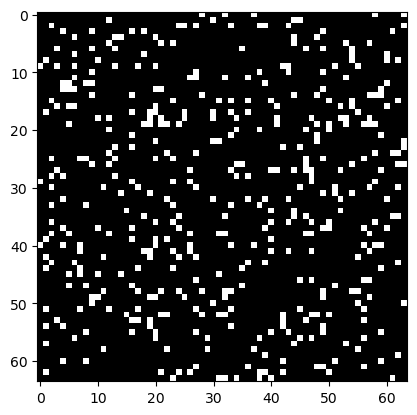

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(mask[0,0,:,:].cpu().numpy(), cmap='gray')

In [ ]:
mask[0,0,:,:].sum()

tensor(431.)

In [ ]:
64*64

4096

In [ ]:
32* 20* 64* 128

5242880

In [ ]:
2440276/(32* 20* 64* 128)

0.46544570922851564

In [ ]:
617011 - 3390257

-2773246

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DepthwiseConv2D(nn.Module):
    def __init__(self, in_channels, kernel_size, stride=1, padding=0, dilation=1, bias=True, depth_multiplier=1, mask_c=False):
        super(DepthwiseConv2D, self).__init__()
        self.out_channels = in_channels * depth_multiplier  # Adjusted for depth_multiplier
        self.depthwise = nn.Conv2d(
            in_channels=in_channels,
            out_channels=self.out_channels,  # Adjusted for depth multiplier
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=in_channels,  # Ensures depthwise convolution
            bias=bias
        )
        self.kernel_size = [kernel_size, kernel_size]
        # Initialize kernel mask
        if mask_c:
            self.register_buffer('kernel_weights', torch.ones_like(self.depthwise.weight, requires_grad=False))
        else:
        self.register_buffer('kernel_weights', torch.ones_like(self.depthwise.weight, requires_grad=False))

    def forward(self, x):      
        
        x = F.conv2d(x, self.kernel_weights, self.depthwise.bias, self.depthwise.stride, 
                     self.depthwise.padding, self.depthwise.dilation, self.depthwise.groups)
        return x

    def initialize_weights(self, method='kaiming'):
        if method == 'kaiming':
            nn.init.kaiming_normal_(self.depthwise.weight, mode='fan_out', nonlinearity='relu')
        elif method == 'xavier':
            nn.init.xavier_normal_(self.depthwise.weight)
        else:
            raise ValueError("Unsupported initialization method")

        if self.depthwise.bias is not None:
            nn.init.constant_(self.depthwise.bias, 0)


In [47]:
dconv = DepthwiseConv2D(3, kernel_size=7, stride=2, dilation=1, padding='valid',bias=False, depth_multiplier=4)

dconv(torch.ones(1,3,64,64))

tensor([[[[49., 49., 49.,  ..., 49., 49., 49.],
          [49., 49., 49.,  ..., 49., 49., 49.],
          [49., 49., 49.,  ..., 49., 49., 49.],
          ...,
          [49., 49., 49.,  ..., 49., 49., 49.],
          [49., 49., 49.,  ..., 49., 49., 49.],
          [49., 49., 49.,  ..., 49., 49., 49.]],

         [[49., 49., 49.,  ..., 49., 49., 49.],
          [49., 49., 49.,  ..., 49., 49., 49.],
          [49., 49., 49.,  ..., 49., 49., 49.],
          ...,
          [49., 49., 49.,  ..., 49., 49., 49.],
          [49., 49., 49.,  ..., 49., 49., 49.],
          [49., 49., 49.,  ..., 49., 49., 49.]],

         [[49., 49., 49.,  ..., 49., 49., 49.],
          [49., 49., 49.,  ..., 49., 49., 49.],
          [49., 49., 49.,  ..., 49., 49., 49.],
          ...,
          [49., 49., 49.,  ..., 49., 49., 49.],
          [49., 49., 49.,  ..., 49., 49., 49.],
          [49., 49., 49.,  ..., 49., 49., 49.]],

         ...,

         [[49., 49., 49.,  ..., 49., 49., 49.],
          [49., 49., 4